In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

### Various functions

In [2]:
def get_ensemble(name,data_vars,htape,keys,paramkey,p=True):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/oleson/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=p,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0' or htape=='h1':
        # NOTE hardcoded start of year here (2002)
        ds['time'] = xr.cftime_range(str(2002),periods=len(ds.time),freq='MS') #fix time bug

    #specify extra variables    
    if htape=='h1':
        extras     = ['pfts1d_lat','pfts1d_lon','pfts1d_wtgcell','pfts1d_itype_veg']
    else:
        extras     = ['grid1d_lat','grid1d_lon']
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax/biome
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds


In [3]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [4]:
def get_cfs():
    df = pd.read_csv('agg_units_Towers.csv')
    cfs   = dict()
    units = dict()
    for i,row in df.iterrows():
        f = row['field']
        u = row['unit']
        c = row['cf']

        if c != 'intrinsic':
            c = float(c)
            
        cfs[f]   = c
        units[f] = u
    return cfs,units

In [5]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])
    
def top_n(da,nx,params,minmax,uniques):
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

def plot20(da,nx,tstr,ll=True,xstr=''):
    
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    xmins,xmaxs,pvals = top_n(da,nx,params,minmax,uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']
    

    
    if len(xstr)==0:
        xstr=tstr
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')');

In [6]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

### Setup the PBSCluster

In [7]:
# Setup your PBSCluster
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

### Check to see if resources have been allocated

In [9]:
client

<Client: 'tcp://10.12.206.48:45696' processes=20 threads=20, memory=465.60 GiB>

### Load ensemble

In [12]:
#fetch the paraminfo
csv = '/glade/u/home/oleson/ppe_tools/jobscripts/PPEn11/SP_ensemble_remove_correlated.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
#la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
#la = xr.open_dataset(la_file).landarea  #km2
# NOTE arbitrary area here (1 km2)
la = 1.0

#fetch unit/cf dicts
cfs,units = get_cfs()

In [13]:
# NOTE hardcoded site here
env = 'CTL2010SP_AT-Neu'
keys = paramkey.key
data_vars = ['FPSN','TWS','EFLX_LH_TOT','FCTR',
             'FCEV','FGEV','QHR','QRUNOFF',
             'QOVER','QDRAI','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']
ds = get_ensemble(env,data_vars,'h0',keys,paramkey)
params = ds.param
minmax = ds.minmax
ds

<xarray.Dataset>
Dimensions:         (ens: 225, time: 132, gridcell: 1)
Coordinates:
  * ens             (ens) int64 0 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
  * time            (time) object 2002-01-01 00:00:00 ... 2012-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables: (12/22)
    FPSN            (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    TWS             (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    EFLX_LH_TOT     (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    FCTR            (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    FCEV            (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    FGEV            (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    ...              ...
    FSH             (ens, time, gridcell) float32 dask.array<chunksize=(1, 132, 1), meta=np.ndarray>
    grid1d_lat      (gridcell) float64 ...
    grid1d_lon      (gridcell) float64 ...
    key             (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0467' 'OAAT0468'
    param           (ens) <U28 'default' 'taulnir' ... 'leaf_mr_vcm' 'fnitr'
    minmax          (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 01/10/22 15:42:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_CTL2010SP_AT-Neu_OAAT...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Function to calculate global annual avg / iav

In [14]:
def calc_mean(ds,datavar,la,dim='gridcell'):

    # NOTE hardcoded domain here
    domain='AT-Neu'
    preload = './data/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/la/365
        x  = ds[datavar]

        #calc annual mean or sum (determined by cf)
        if datavar=='ALTMAX':
            ## unique logic for ALTMAX
            # NOTE hardcoded number of years here (1)
            ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<1
            xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim=dim).compute()
        else:
            # NOTE hardcoded number of years here (month_wts(11))
            xann = cf*(month_wts(11)*(la*x).sum(dim=dim)).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')
        
        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = ds.param
        out['minmax'] = ds.minmax
        out.load().to_netcdf(preload)
    

    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

### GPP (FPSN)

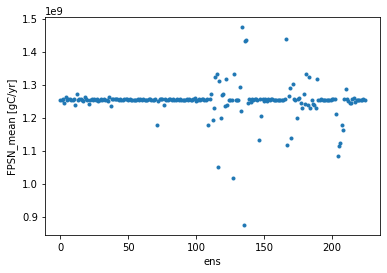

In [15]:
datavar = 'FPSN'
gpp,iav = calc_mean(ds,datavar,la,dim='gridcell')
gpp.plot.line('.');

In [16]:
#which perturbations yield the bottom 20 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp)[:20]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW GPP:
   jmaxb1-min
   tpu25ratio-min
   theta_cj-min
   jmaxb0-min
   wc2wjb0-min
   leafcn-max
   medlynintercept-max
   kmax-min
   jmaxha-max
   tpuha-max
   liq_canopy_storage_scalar-max
   vcmaxha-max
   medlynslope-max
   fnps-max
   kc25_coef-min
   kcha-min
   krmax-min
   medlynslope-min
   slatop-max
   theta_psii-min


In [17]:
#which perturbations yield the top 20 highest GPP?
print('HIGH GPP:')
for i in np.flip(np.argsort(gpp))[:20]:
    print(i)
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

HIGH GPP:
<xarray.DataArray 'FPSN_mean' ()>
array(134)
Coordinates:
    ens      int64 224
Attributes:
    units:    gC/yr
   jmaxb0-max
<xarray.DataArray 'FPSN_mean' ()>
array(166)
Coordinates:
    ens      int64 223
Attributes:
    units:    gC/yr
   leafcn-min
<xarray.DataArray 'FPSN_mean' ()>
array(137)
Coordinates:
    ens      int64 222
Attributes:
    units:    gC/yr
   wc2wjb0-max
<xarray.DataArray 'FPSN_mean' ()>
array(136)
Coordinates:
    ens      int64 221
Attributes:
    units:    gC/yr
   jmaxb1-max
<xarray.DataArray 'FPSN_mean' ()>
array(128)
Coordinates:
    ens      int64 220
Attributes:
    units:    gC/yr
   tpu25ratio-max
<xarray.DataArray 'FPSN_mean' ()>
array(115)
Coordinates:
    ens      int64 219
Attributes:
    units:    gC/yr
   theta_ip-max
<xarray.DataArray 'FPSN_mean' ()>
array(181)
Coordinates:
    ens      int64 218
Attributes:
    units:    gC/yr
   jmaxhd-min
<xarray.DataArray 'FPSN_mean' ()>
array(183)
Coordinates:
    ens      int64 217
Attributes:
 

### QRUNOFF

<xarray.DataArray 'QRUNOFF_mean' (ens: 225)>
array([173894.188996, 169134.858352, 179537.985922, ..., 170919.824788,
       176743.252345, 173894.188996])
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 217 218 219 220 221 222 223 224
Attributes:
    units:    tH2O/yr


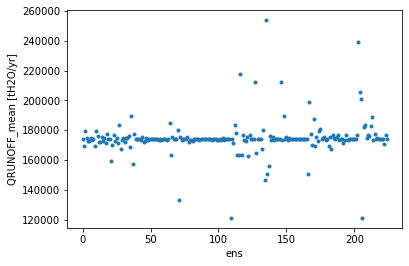

In [18]:
datavar = 'QRUNOFF'
qrunoff,iav = calc_mean(ds,datavar,la,dim='gridcell')
print(qrunoff)
qrunoff.plot.line('.');

In [19]:
#which perturbations yield the bottom 20 lowest QRUNOFF?
print('LOW QRUNOFF:')
for i in np.argsort(qrunoff)[:20]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW QRUNOFF:
   medlynslope-max
   medlynintercept-max
   liq_canopy_storage_scalar-max
   jmaxb0-max
   leafcn-min
   jmaxb1-max
   wc2wjb0-max
   frac_sat_soil_dsl_init-min
   dleaf-min
   cp25_yr2000-min
   maximum_leaf_wetted_fraction-max
   theta_ip-max
   theta_psii-max
   theta_cj-max
   tpu25ratio-max
   cv-max
   tpuhd-min
   slatop-min
   d_max-min
   rholnir-min


In [20]:
#which perturbations yield the top 20 highest QRUNOFF?
print('HIGH QRUNOFF:')
for i in np.flip(np.argsort(qrunoff))[:20]:
    print(i)
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

HIGH QRUNOFF:
<xarray.DataArray 'QRUNOFF_mean' ()>
array(135)
Coordinates:
    ens      int64 224
Attributes:
    units:    tH2O/yr
   jmaxb1-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(203)
Coordinates:
    ens      int64 223
Attributes:
    units:    tH2O/yr
   medlynslope-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(116)
Coordinates:
    ens      int64 222
Attributes:
    units:    tH2O/yr
   theta_cj-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(127)
Coordinates:
    ens      int64 221
Attributes:
    units:    tH2O/yr
   tpu25ratio-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(146)
Coordinates:
    ens      int64 220
Attributes:
    units:    tH2O/yr
   kmax-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(204)
Coordinates:
    ens      int64 219
Attributes:
    units:    tH2O/yr
   jmaxb0-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(205)
Coordinates:
    ens      int64 218
Attributes:
    units:    tH2O/yr
   wc2wjb0-min
<xarray.DataArray 'QRUNOFF_mean' ()>
array(167)
Coor

### Plot range of GPP (FPSN) avg/iav for min/max parameter perturbations

<xarray.DataArray 'FPSN_mean' (ens: 225)>
array([1.254746e+09, 1.251930e+09, 1.257630e+09, ..., 1.253755e+09,
       1.255368e+09, 1.254746e+09])
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 217 218 219 220 221 222 223 224
Attributes:
    units:    gC/yr


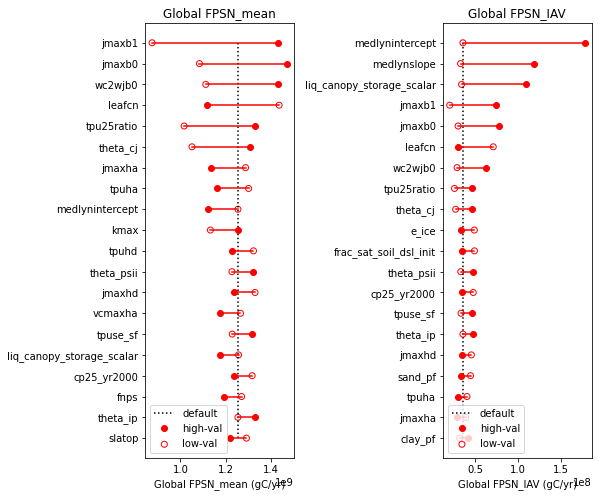

In [21]:
datavar = 'FPSN'
gpp,iav = calc_mean(ds,datavar,la,dim='gridcell')
print(gpp)
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(gpp,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### Print gpp for max and min sand_pf

In [22]:
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='max')
print(gpp[ix])
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='min')
print(gpp[ix])

<xarray.DataArray 'FPSN_mean' (ens: 1)>
array([1.257803e+09])
Coordinates:
  * ens      (ens) int64 215
Attributes:
    units:    gC/yr
<xarray.DataArray 'FPSN_mean' (ens: 1)>
array([1.245576e+09])
Coordinates:
  * ens      (ens) int64 214
Attributes:
    units:    gC/yr


### Plot range of QRUNOFF avg/iav for min/max parameter perturbations

<xarray.DataArray 'QRUNOFF_mean' (ens: 225)>
array([173894.188996, 169134.858352, 179537.985922, ..., 170919.824788,
       176743.252345, 173894.188996])
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 217 218 219 220 221 222 223 224
Attributes:
    units:    tH2O/yr


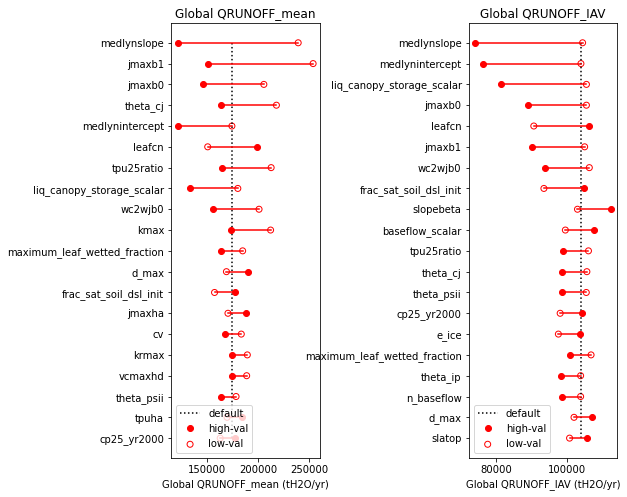

In [23]:
datavar = 'QRUNOFF'
qrunoff,iav = calc_mean(ds,datavar,la,dim='gridcell')
print(qrunoff)
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(qrunoff,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### SNOWDP

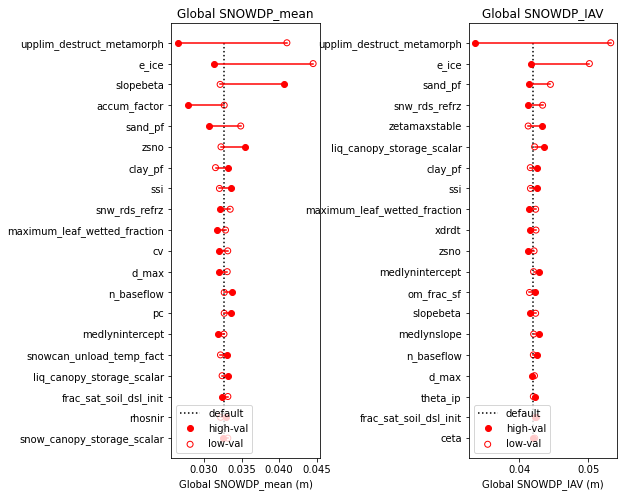

In [24]:
datavar = 'SNOWDP'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### EFLX_LH_TOT

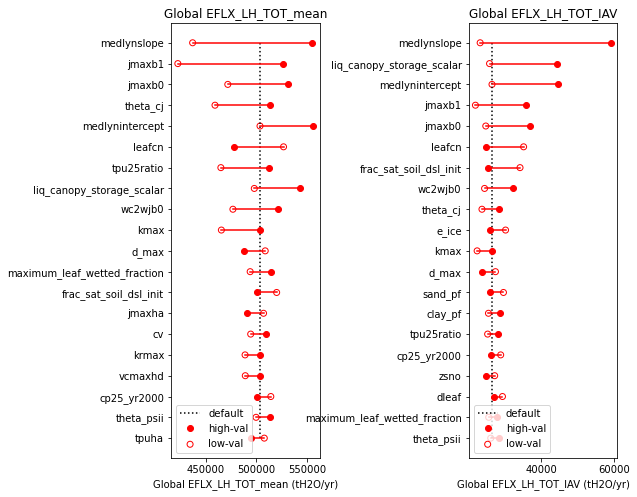

In [25]:
datavar = 'EFLX_LH_TOT'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### Print eflx_lt_tot for max and min sand_pf

In [26]:
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='max')
print(da[ix])
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='min')
print(da[ix])

<xarray.DataArray 'EFLX_LH_TOT_mean' (ens: 1)>
array([501344.128717])
Coordinates:
  * ens      (ens) int64 215
Attributes:
    units:    tH2O/yr
<xarray.DataArray 'EFLX_LH_TOT_mean' (ens: 1)>
array([503030.360796])
Coordinates:
  * ens      (ens) int64 214
Attributes:
    units:    tH2O/yr


### FSH

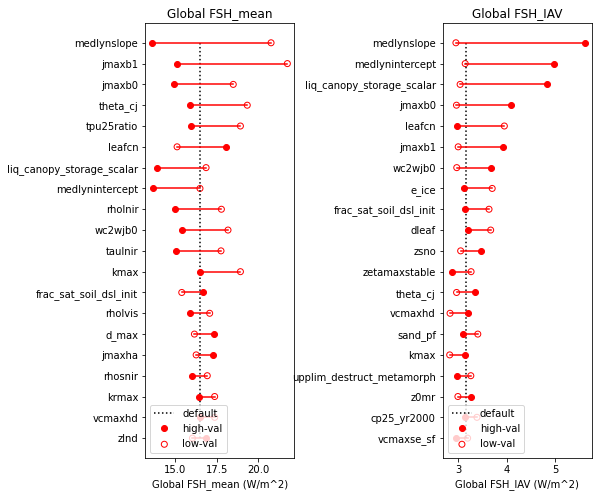

In [27]:
datavar = 'FSH'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### SOIlWATER_10CM

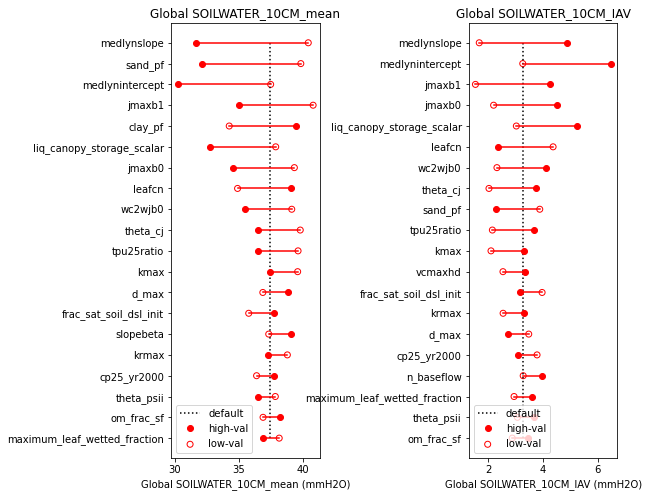

In [28]:
datavar = 'SOILWATER_10CM'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### Print soilwater_10cm for min and max sand_pf

In [29]:
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='max')
print(da[ix])
ix  = np.logical_and(ds.param=='sand_pf',ds.minmax=='min')
print(da[ix])

<xarray.DataArray 'SOILWATER_10CM_mean' (ens: 1)>
array([32.157532])
Coordinates:
  * ens      (ens) int64 215
Attributes:
    units:    mmH2O
<xarray.DataArray 'SOILWATER_10CM_mean' (ens: 1)>
array([39.821056])
Coordinates:
  * ens      (ens) int64 214
Attributes:
    units:    mmH2O


### Example for daily variability

In [32]:
#fetch the paraminfo
csv = '/glade/u/home/oleson/ppe_tools/jobscripts/PPEn11/SP_ensemble_remove_correlated.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
#la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
#la = xr.open_dataset(la_file).landarea  #km2
# NOTE arbitrary area here (1 km2)
la = 1.0

#fetch unit/cf dicts
cfs,units = get_cfs()

In [34]:
# NOTE the hardcoded site here
env = 'CTL2010SP_AT-Neu'
keys = paramkey.key
data_vars = ['SOILWATER_10CM','FPSN','EFLX_LH_TOT','TWS']
ds = get_ensemble(env,data_vars,'h4',keys,paramkey)
params = ds.param
minmax = ds.minmax

### SOILWATER_10CM

In [35]:
# NOTE the hardcoded number of days here (366)
ix = np.arange(4019)>0
sw = 1/la*(la*ds.SOILWATER_10CM.isel(time=ix).std(dim='time')).sum(dim='gridcell').compute()
sw.attrs={'units':'mmH2O'}

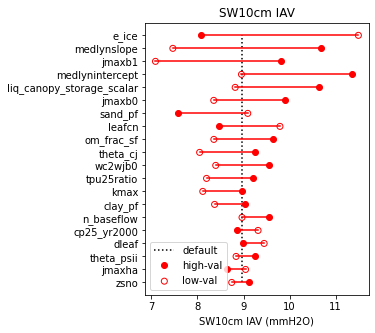

In [36]:
plt.figure(figsize=[4,5])
plot20(sw,20,'SW10cm IAV')